# Main text figures

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
import xarray as xr
import pandas as pd
import copy
import scipy
import glob
from scipy import signal

# OS interaction
import os
import sys

# import plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from pydmd.costs import COSTS
from pydmd.mrcosts import mrCOSTS
import string
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

import warnings

warnings.filterwarnings("ignore")

## Format plots

In [2]:
from matplotlib.collections import Collection
from matplotlib.artist import allow_rasterization


class ListCollection(Collection):
    def __init__(self, collections, **kwargs):
        Collection.__init__(self, **kwargs)
        self.set_collections(collections)

    def set_collections(self, collections):
        self._collections = collections

    def get_collections(self):
        return self._collections

    @allow_rasterization
    def draw(self, renderer):
        for _c in self._collections:
            _c.draw(renderer)


def insert_rasterized_contour_plot(c):
    collections = c.collections
    for _c in collections:
        _c.remove()
    cc = ListCollection(collections, rasterized=True)
    ax = plt.gca()
    ax.add_artist(cc)
    return cc

In [3]:
# Set the plot style from the seaborn library
sns.set_style("whitegrid", {"xtick.bottom": True, "ytick.left": True})
small_font = 8
plt.rc("font", size=small_font)
plt.rc("axes", titlesize=small_font)
plt.rc("axes", labelsize=small_font)
plt.rc("xtick", labelsize=small_font)
plt.rc("ytick", labelsize=small_font)
plt.rc("legend", fontsize=small_font)
plt.rc("figure", titlesize=small_font)
plt.rcParams["legend.title_fontsize"] = small_font

# Tol bright color scheme reordered to put my favorite colors first
tol_bright_reorder = [
    "#4477AA",
    "#CCBB44",
    "#EE6677",
    "#228833",
    "#66CCEE",
    "#AA3377",
    "#BBBBBB",
]
sns.set_palette(sns.color_palette(tol_bright_reorder))
alphabet = string.ascii_lowercase

# Data

Re-running this cell more than once will likely break the logic we are using here for setting up the directory structure.

In [4]:
dir_notebook = os.getcwd()
dir_data = os.path.join(dir_notebook, "data")
dir_print = os.path.join(dir_notebook, "figures")
dir_results = os.path.join(dir_notebook, "mrCOSTS fit")

In [5]:
components = ["w", "u", "v"]
domain_list = ["1km", "500m", "250m", "125m", "lidar"]
domain_titles_dict = {
    "1km": "DX1000",
    "500m": "DX500",
    "250m": "DX250",
    "125m": "DX125",
    "lidar": "lidar",
}

os.chdir(dir_data)
ds_data = {}
for domain in domain_list:
    ds_data[domain] = xr.open_dataset(f"{domain}.publication-version.nc").load()

    # For these plots we need to transpose the model data ahead of time. 
    if not domain == "lidar":
        for comp in components:
            ds_data[domain][comp] = ds_data[domain][comp].T
    

ts = ds_data["lidar"].time
ts = ts - ts.isel(time=0)
ts = (ts / 1e9).values.astype(float)
# Time step in seconds
dt = 80

Here we build a lidar mask so that the periods where the signal to noise ratio is insufficient are not included in the analysis.

In [6]:
os.chdir(dir_data)
lidar_mask = xr.open_dataset("lidar-mask.publication-version.nc")
lidar_mask = lidar_mask.resample(time="80s").nearest(tolerance="2min")
lidar_mask = lidar_mask.rename({"vcomp": "mask"}).mask
lidar_mask = xr.where(np.isnan(lidar_mask), 1, np.nan)

## Load the mrCOSTS fits

In [7]:
os.chdir(dir_results)
strategy = "conj-pair"
mrc_dict = {}

for domain in domain_list:
    fnames = "*".join(["", domain, strategy, ".nc"])
    file_list = glob.glob(fnames)
    mrc = mrCOSTS()
    mrc.from_netcdf(file_list)
    mrc_dict[domain] = mrc

# Prepare results

## Scale separation

In [8]:
# Note I made some subjective decisions by choosing the largest
# number of justifiable bands in order to best separate the
# bands.
n_optimal_dict = {
    "1km": 20,
    "500m": 15,
    "250m": 11,
    "125m": 23,
    "lidar": 18,
}

for ndomain, domain in enumerate(domain_list):

    mrc = mrc_dict[domain]

    cluster_centroids, omega_classes, omega_array = mrc.global_cluster_omega(
        n_optimal_dict[domain], transform_method="log10"
    )

## Reconstruct

The wind components are rotated into the valley axis to give a better physical interpretation. The rotation necessary is about 20 degrees, so relatively minor. But technically correct is the best kind of correct.

In [10]:
def _angle_transform(x, y, alpha):
    """Rotate the wind vector using the angle `alpha`.
    """
    trans_x = x * np.cos(alpha) + y * np.sin(alpha)
    trans_y = -x * np.sin(alpha) + y * np.cos(alpha)
    return trans_x, trans_y

In [11]:
alpha = 20 * np.pi / 180
xr_global_dict = {}
xr_sep_dict = {}
xr_background_dict = {}
for domain in domain_list:
    mrc = mrc_dict[domain]

    xr_sep = mrc.global_scale_reconstruction()
    xr_background = mrc.get_background()
    xr_global = xr_sep.sum(axis=(0, 1)) + xr_background

    xr_global_w, xr_global_u, xr_global_v = np.split(
        xr_global, indices_or_sections=3, axis=0
    )
    along, across = _angle_transform(xr_global_u, xr_global_v, alpha)
    xr_global_dict[domain] = {
        "w": xr_global_w,
        "u": along,
        "v": across,
    }

    xr_sep_w, xr_sep_u, xr_sep_v = np.split(xr_sep, indices_or_sections=3, axis=2)
    along, across = _angle_transform(xr_sep_u, xr_sep_v, alpha)
    xr_sep_dict[domain] = {
        "w": xr_sep_w,
        "u": along,
        "v": across,
    }

    xr_background_w, xr_background_u, xr_background_v = np.split(
        xr_background, indices_or_sections=3, axis=0
    )
    along, across = _angle_transform(xr_background_u, xr_background_v, alpha)
    xr_background_dict[domain] = {
        "w": xr_background_w,
        "u": along,
        "v": across,
    }

## Specify band ranges

These are the aggregated bands we use in the manuscript (turbulence, MoBL, and diurnal scales).

In [12]:
def to_period(cluster_centers):
    cl_periods = (2 * np.pi) / 10**cluster_centers
    return cl_periods

The largest time scale truly resolved by mrCOSTS should not be larger than the window length.

In [13]:
largest_resolved_timescale = np.max(mrc.window_length_array)
(largest_resolved_timescale * dt)

52000

For the LIDAR decomposition, no global frequency is larger than the largest decomposition level's window length. This may not be true for the ICON decompositions so we need to make sure to enforce it.

In [14]:
band_ranges_old = [
    (100, 1000),
    (1000, 4000),
    (4000, 8000),
    (8000, 52000),
    (52000, 200000),
]

largest_dt = largest_resolved_timescale * dt
band_ranges = [(100, 4000), (4000, 9000), (9000, largest_dt)]

## Build xarray Datasets

### All bands

In [15]:
ds_recon_list = {}
for domain in domain_list:
    mrc = mrc_dict[domain]
    cluster_centers_periods = 1 / (10 ** (mrc.cluster_centroids) / (2 * np.pi))

    ds = xr.Dataset(
        {
            "w": (["band", "height", "time"], xr_sep_dict[domain]["w"].sum(axis=0)),
            "u": (["band", "height", "time"], xr_sep_dict[domain]["u"].sum(axis=0)),
            "v": (["band", "height", "time"], xr_sep_dict[domain]["v"].sum(axis=0)),
        },
        coords={
            "height": ds_data[domain].height.data,
            "time": ds_data[domain].time.data,
            "band": cluster_centers_periods,
        },
    )
    ds_recon_list[domain] = ds
ds_icon_dx125m = ds_recon_list["125m"]
ds_lidar_xr = ds_recon_list["lidar"]

### Background mode

In [16]:
ds_background_dict = {}
for domain in domain_list:
    mrc = mrc_dict[domain]
    cluster_centers_periods = 1 / (10 ** (mrc.cluster_centroids) / (2 * np.pi))

    ds = xr.Dataset(
        {
            "w": (["height", "time"], xr_background_dict[domain]["w"]),
            "u": (["height", "time"], xr_background_dict[domain]["u"]),
            "v": (["height", "time"], xr_background_dict[domain]["v"]),
        },
        coords={
            "height": ds_data[domain].height.data,
            "time": ds_data[domain].time.data,
        },
    )
    ds_background_dict[domain] = ds

### Rotated turbulent component

The turbulent band is rotated to be in the direction of the wind from all of the non-turbulent bands. This is done so that the covariance $u'w'$ specifies if the momentum is transported into or against the main flow.

In [17]:
domain = "lidar"
plot_band = band_ranges[0]
cluster_centers_periods = to_period(mrc_dict[domain].cluster_centroids)
band_index = np.flatnonzero(
    (cluster_centers_periods > plot_band[0]) & (cluster_centers_periods < plot_band[1])
)
ds_turb = ds_lidar_xr.isel(band=band_index).sum(dim="band")
ds_turb = xr.where(np.isnan(lidar_mask), np.nan, ds_turb)

In [18]:
# Add together all bands larger than turbulence
plot_band = band_ranges[0]
cluster_centers_periods = to_period(mrc_dict[domain].cluster_centroids)
band_index = np.flatnonzero((cluster_centers_periods > plot_band[1]))
ds_nonturb = ds_lidar_xr.isel(band=band_index).sum(dim="band")

# Include the background flow
for c in components:
    ds_nonturb[c] = ds_nonturb[c] + xr_background_dict[domain][c]
ds_nonturb = xr.where(np.isnan(lidar_mask), np.nan, ds_nonturb)

# Calculate and plot
phi = np.arctan2(ds_nonturb.v, ds_nonturb.u)
along, across = _angle_transform(ds_nonturb["u"], ds_nonturb["v"], phi)
ds_nonturb_rotated = xr.Dataset()
ds_nonturb_rotated["u_rotated"] = along
ds_nonturb_rotated["v_rotated"] = across

# And recalculate for the turbulent wind components
turb_along, turb_across = _angle_transform(ds_turb["u"], ds_turb["v"], phi)
ds_turb_rotated = xr.Dataset()
ds_turb_rotated["u"] = turb_along
ds_turb_rotated["v"] = turb_across
ds_turb_rotated["w"] = ds_turb.w.copy()
ds_turb_rotated["tke"] = (
    ds_turb_rotated["u"] ** 2 + ds_turb_rotated["v"] ** 2 + ds_turb_rotated["w"] ** 2
) / 2

# Stamp plots (SI Figures)

In [23]:
domain_titles = {
    "1km": "DX1000",
    "500m": "DX500",
    "250m": "DX250",
    "125m": "DX125",
    "lidar": "lidar",
}

In [19]:
def add_colorbar(ax, fig, pcolor_kwargs, label, inset_loc=[0.075, 0.9, 0.35, 0.075]):
    norm = matplotlib.colors.Normalize(
        vmin=pcolor_kwargs["vmin"], vmax=pcolor_kwargs["vmax"]
    )
    cax = ax.inset_axes(inset_loc)
    cbar = fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=norm, cmap=pcolor_kwargs["cmap"]),
        cax=cax,
        orientation="horizontal",
        shrink=0.2,
    )
    cbar.set_label(label, labelpad=-0.8)

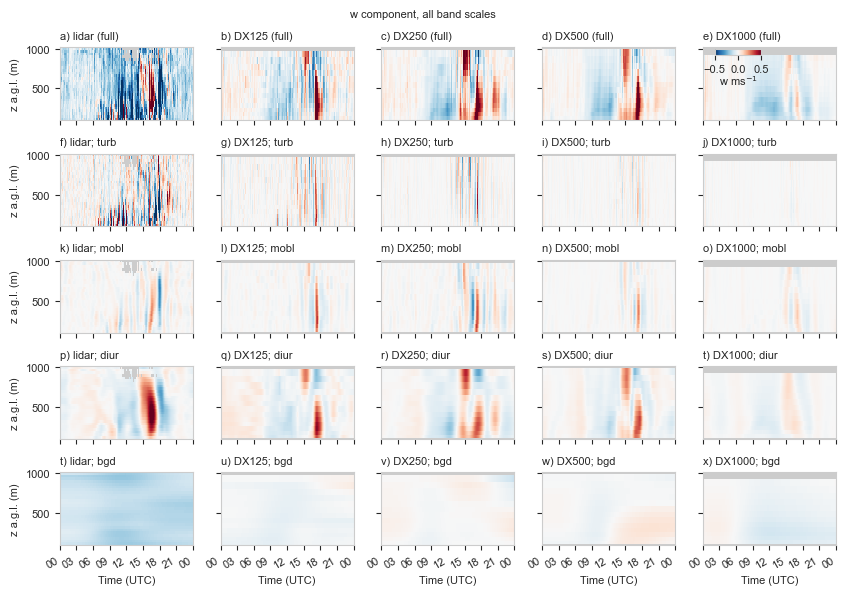

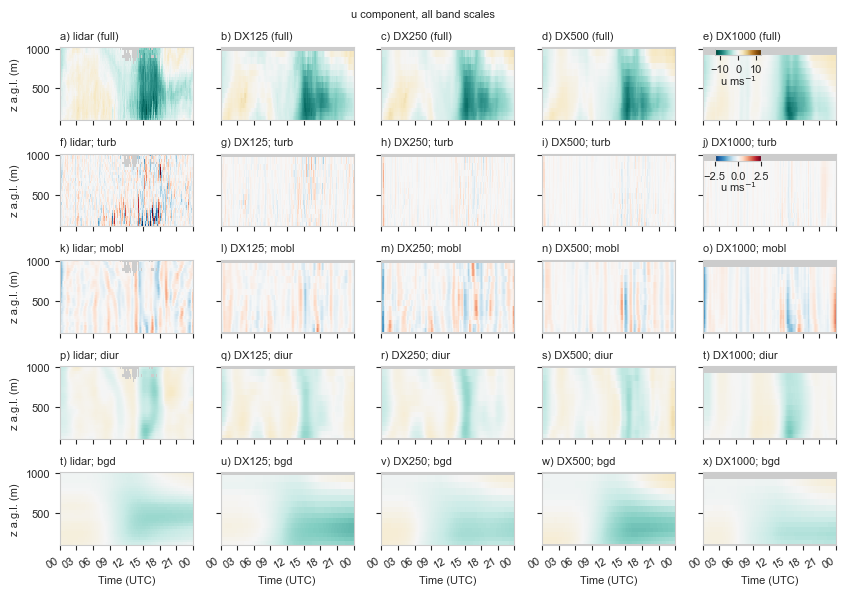

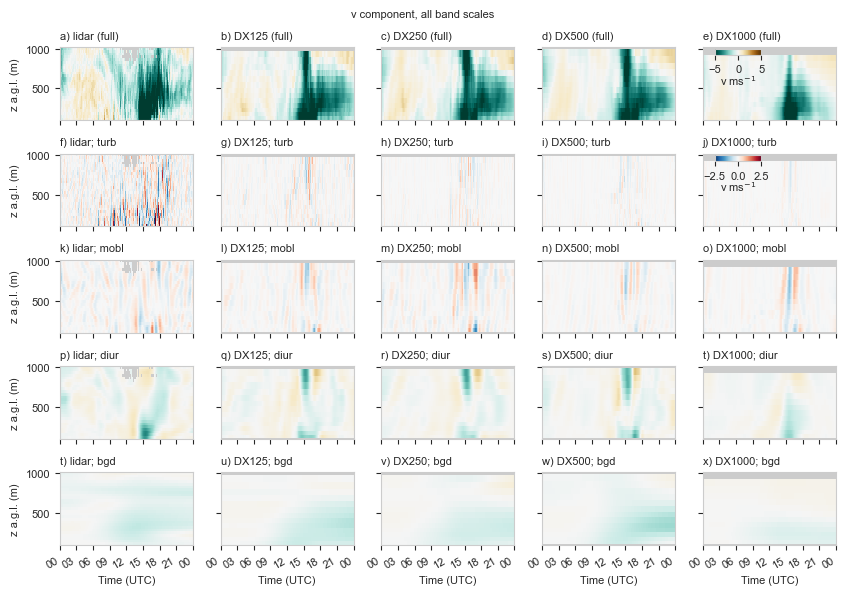

In [24]:
cmap = plt.get_cmap("RdBu_r").copy()
cmap.set_bad("0.8")
pcolor_kwargs_u_small = {
    "vmin": -2.5,
    "vmax": 2.5,
    "cmap": cmap,
    # "step": 0.25
}
# pcolor_kwargs_u_small = build_contour_kwargs(pcolor_kwargs_u_small)

cmap = plt.get_cmap("RdBu_r").copy()
cmap.set_bad("0.8")
pcolor_kwargs_w = {
    "vmin": -0.5,
    "vmax": 0.5,
    "cmap": cmap,
    # "step": 0.1,
}
# pcolor_kwargs_w = build_contour_kwargs(pcolor_kwargs_w)

cmap = plt.get_cmap("BrBG_r").copy()
cmap.set_bad("0.8")
pcolor_kwargs_u_large = {
    "vmin": -13.0,
    "vmax": 13.0,
    "cmap": cmap,
    # "step": 1,
}
# pcolor_kwargs_u_large = build_contour_kwargs(pcolor_kwargs_u_large)

cmap = plt.get_cmap("BrBG_r").copy()
cmap.set_bad("0.8")
pcolor_kwargs_v_large = {
    "vmin": -5.0,
    "vmax": 5.0,
    "cmap": cmap,
    # "step": 1,
}

date_format = DateFormatter("%H")
band_range_names = ["turb", "mobl", "diur", "bgd"]

for ncomp, comp in enumerate(components):
    fig, axes = plt.subplots(
        len(band_ranges) + 2, 5, figsize=(8.5, 6), sharex=True, sharey=True
    )
    cbar_label = f"{comp} ms$^{{-1}}$"

    for nd, domain in enumerate(reversed(domain_list)):
        if domain == "lidar":
            domain_name = "lidar"
        else:
            # domain_name = f"icon $\Delta$x={domain}"
            domain_name = domain_titles[domain]
        mrc = mrc_dict[domain]
        mrc.multi_res_interp()
        cluster_centroids, omega_classes, omega_array = mrc.global_cluster_omega(
            n_optimal_dict[domain], transform_method="log10"
        )
        cluster_centers_periods = 1 / (10 ** (cluster_centroids) / (2 * np.pi))

        # Plot the full observations
        ds = ds_data[domain][comp]
        if domain == "lidar":
            ds = xr.where(np.isnan(lidar_mask), np.nan, ds)
        if comp == "u":
            pcolor_kwargs = pcolor_kwargs_u_large
        if comp == "v":
            pcolor_kwargs = pcolor_kwargs_v_large
        if comp == "w":
            pcolor_kwargs = pcolor_kwargs_w
        title = f"{alphabet[nd]}) {domain_name} (full)"
        ax = axes[0, nd]
        ax.pcolormesh(ds.time, ds.height, ds, **pcolor_kwargs)
        ax.xaxis.set_major_formatter(date_format)
        ax.set_facecolor("0.8")
        ax.grid(False)
        if nd == 0:
            ax.set_ylabel("z a.g.l. (m)")
        ax.set_title(title, loc="left")
        if domain == "1km":
            add_colorbar(
                ax, fig, pcolor_kwargs, cbar_label, inset_loc=[0.09, 0.9, 0.35, 0.075]
            )

        # Now get the banded reconstruction
        ds_comp = ds_recon_list[domain][comp]
        for nband, band in enumerate(band_ranges):
            # for nband, band in enumerate(band_ranges_adjuste_mobl):
            if nband > 1 and comp == "u":
                pcolor_kwargs = pcolor_kwargs_u_large
            elif nband > 1 and comp == "v":
                pcolor_kwargs = pcolor_kwargs_v_large
            elif not comp == "w":
                pcolor_kwargs = pcolor_kwargs_u_small
            elif comp == "w":
                pcolor_kwargs = pcolor_kwargs_w

            # Select just the band in question
            band_index = np.flatnonzero(
                (cluster_centers_periods > band[0])
                & (cluster_centers_periods < band[1])
            )
            ds = ds_comp.isel(band=band_index).sum(dim="band")
            if domain == "lidar":
                ds = xr.where(np.isnan(lidar_mask), np.nan, ds)

            ax = axes[nband + 1, nd]
            ax.pcolormesh(
                ds.time,
                ds.height,
                ds.values,
                **pcolor_kwargs,
            )
            title = f"{alphabet[(nband + 1) * 5 + nd]}) {domain_name}; {band_range_names[nband]}"
            ax.set_title(title, loc="left")
            ax.xaxis.set_major_formatter(date_format)
            ax.set_facecolor("0.8")
            ax.grid(False)
            if nband == 3:
                ax.set_xlabel("Time (UTC)")
            if nd == 0:
                ax.set_ylabel("z a.g.l. (m)")

            if (comp == "u" or comp == "v") and domain == "1km" and nband == 0:
                add_colorbar(
                    ax,
                    fig,
                    pcolor_kwargs,
                    cbar_label,
                    inset_loc=[0.09, 0.9, 0.35, 0.075],
                )

        # Include the poorly resolved components to the background
        ax = axes[-1, nd]
        x_plot = ds_background_dict[domain][comp].copy()
        # band_poorly_resolved = np.flatnonzero(cluster_centers_periods > largest_dt)
        # if band_poorly_resolved.size > 0:
        #     x_plot += ds_comp.isel(band=band_poorly_resolved).sum(dim="band")
        ax.pcolormesh(ds.time, ds.height, x_plot, **pcolor_kwargs)
        ax.xaxis.set_major_formatter(date_format)
        ax.set_facecolor("0.8")
        ax.grid(False)
        title = f"{alphabet[nd + 19]}) {domain_name}; bgd"
        ax.set_title(title, loc="left")
        ax.set_xlabel("Time (UTC)")
        if nd == 0:
            ax.set_ylabel("z a.g.l. (m)")

    fig.autofmt_xdate()
    fig.suptitle(f"{comp} component, all band scales")
    fig.tight_layout()

    os.chdir(dir_print)
    fig.savefig(f"stamp-plot.comp={comp}.rotated.png", dpi=300, bbox_inches="tight")
    fig.savefig(f"stamp-plot.comp={comp}.rotated.pdf", dpi=300, bbox_inches="tight")
    fig.savefig(f"stamp-plot.comp={comp}.rotated.jpg", dpi=300, bbox_inches="tight")

# Turbulent scales

In [25]:
def detrend_variance(ds, dim):  # axis):
    """Helper function for linearly detrending data prior to calculating the variance profiles."""
    fit = ds.polyfit(dim=dim, deg=1)
    y_fit = xr.polyval(coord=ds[dim], coeffs=fit.polyfit_coefficients)
    y_detrend = ds - y_fit
    return y_detrend.std(dim=dim)

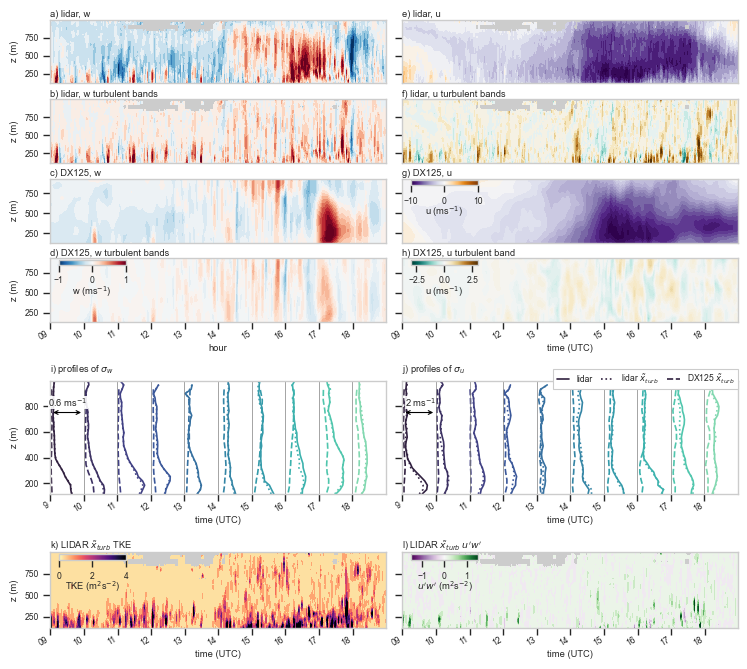

In [27]:
with (sns.plotting_context("paper", font_scale=0.7),):

    cm = 1 / 2.54  # centimeters in inches
    fig = plt.figure(figsize=(19 * cm, 17 * cm))

    gs = gridspec.GridSpec(3, 1, figure=fig, height_ratios=[4, 1.5, 1])
    gs_stamps = gs[0].subgridspec(4, 2, wspace=0.05, hspace=0.25)
    gs_profiles = gs[1].subgridspec(1, 2, hspace=0.05, wspace=0.05)
    gs_turb = gs[2].subgridspec(1, 2, hspace=0.05, wspace=0.05)

    axes_stamps_u = []
    axes_stamps_w = []
    for n in range(4):
        axes_stamps_w.append(fig.add_subplot(gs_stamps[n, 0]))
        axes_stamps_u.append(fig.add_subplot(gs_stamps[n, 1]))

    ax_profile_w = fig.add_subplot(gs_profiles[0, 0])
    ax_profile_u = fig.add_subplot(gs_profiles[0, 1])
    ax_turb_tke = fig.add_subplot(gs_turb[0, 0])
    ax_turb_uw = fig.add_subplot(gs_turb[0, 1])

    cmap = plt.get_cmap("BrBG_r").copy()
    cmap.set_bad("0.8")
    pcolor_kwargs_u_pert = {
        "vmin": -3.0,
        "vmax": 3.0,
        "cmap": cmap,
    }
    cmap = plt.get_cmap("RdBu_r").copy()
    cmap.set_bad("0.8")
    pcolor_kwargs_w = {
        "vmin": -1,
        "vmax": 1,
        "cmap": cmap,
    }
    cmap = plt.get_cmap("PuOr_r").copy()
    cmap.set_bad("0.8")
    pcolor_kwargs_u_full = {
        "vmin": -10,
        "vmax": 10,
        "cmap": cmap,
    }
    pad = 2

    plot_band = band_ranges[0]

    t1 = pd.Timestamp("2019-09-14 09:00")
    t2 = pd.Timestamp("2019-09-14 18:59")
    tslice = slice(t1, t2)

    date_format = DateFormatter("%H")

    # ---------------------------------------------------------
    # LIDAR
    domain = "lidar"
    comp = "w"
    cluster_centers_periods = to_period(mrc_dict[domain].cluster_centroids)
    mrc = mrc_dict[domain]

    # Observations
    ds_obs_sub = ds_data["lidar"][comp].sel(time=slice(t1, t2))
    ds_obs_sub = xr.where(np.isnan(lidar_mask.sel(time=tslice)), np.nan, ds_obs_sub)

    ax = axes_stamps_w[0]
    ax.contourf(
        ds_obs_sub.time,
        ds_obs_sub.height,
        ds_obs_sub,
        levels=20,
        **pcolor_kwargs_w,
    )
    ax.set_facecolor("0.8")
    ax.set_title(f"a) {domain}, {comp}", loc="left", pad=pad)
    ax.xaxis.set_major_formatter(date_format)
    ax.set_xticks([])
    ax.grid(False)
    ax.set_xlim(t1, t2)
    ax.set_ylabel("z (m)")

    # LIDAR mrCOSTS turbulent
    band_index = np.flatnonzero(
        (cluster_centers_periods > plot_band[0])
        & (cluster_centers_periods < plot_band[1])
    )
    ds = ds_lidar_xr[comp].isel(band=band_index).sum(dim="band").sel(time=slice(t1, t2))
    ds = xr.where(np.isnan(lidar_mask.sel(time=tslice)), np.nan, ds)

    ax = axes_stamps_w[1]
    ax.contourf(
        ds.time,
        ds.height,
        ds,
        levels=20,
        **pcolor_kwargs_w,
    )
    ax.set_title(
        f"b) {domain}, {comp} turbulent bands",
        loc="left",
        pad=pad,
    )
    ax.xaxis.set_major_formatter(date_format)
    ax.set_xticks([])
    ax.set_facecolor("0.8")
    ax.grid(False)
    ax.set_xlim(t1, t2)
    ax.set_ylabel("z (m)")

    # ---------------------------------------------------------
    # ICON dx=125m
    domain = "125m"
    cluster_centers_periods = to_period(mrc_dict[domain].cluster_centroids)
    mrc = mrc_dict[domain]

    # Full data
    ds_obs_sub = ds_data[domain][comp].sel(time=slice(t1, t2))

    ax = axes_stamps_w[2]
    ax.contourf(
        ds_obs_sub.time,
        ds_obs_sub.height,
        ds_obs_sub,
        levels=20,
        **pcolor_kwargs_w,
    )
    ax.set_facecolor("0.8")
    dtitle = domain_titles_dict[domain]
    ax.set_title(f"c) {dtitle}, {comp}", loc="left", pad=pad)
    ax.xaxis.set_major_formatter(date_format)
    ax.set_xticks([])
    ax.grid(False)
    ax.set_xlim(t1, t2)
    ax.set_ylabel("z (m)")

    # ICON dx=125m mrCOSTS turbulent
    band_index = np.flatnonzero(
        (cluster_centers_periods > plot_band[0])
        & (cluster_centers_periods < plot_band[1])
    )
    ds = (
        ds_icon_dx125m[comp]
        .isel(band=band_index)
        .sum(dim="band")
        .sel(time=slice(t1, t2))
    )

    ax = axes_stamps_w[3]
    ax.contourf(
        ds.time,
        ds.height,
        ds,
        levels=20,
        **pcolor_kwargs_w,
    )
    dtitle = domain_titles_dict[domain]
    ax.set_title(
        f"d) {dtitle}, {comp} turbulent bands",
        loc="left",
        pad=pad,
    )
    ax.xaxis.set_major_formatter(date_format)
    ax.set_facecolor("0.8")
    ax.grid(False)
    ax.set_xlabel("hour", labelpad=pad)
    ax.tick_params(axis="x", which="major", pad=0.01)  # move the tick labels
    ax.set_xlim(t1, t2)
    ax.set_ylabel("z (m)")

    # Colorbar
    norm = matplotlib.colors.Normalize(
        vmin=pcolor_kwargs_w["vmin"], vmax=pcolor_kwargs_w["vmax"]
    )
    cax = ax.inset_axes([0.025, 0.9, 0.2, 0.075])
    cbar = fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=norm, cmap=pcolor_kwargs_w["cmap"]),
        cax=cax,
        orientation="horizontal",
        shrink=0.2,
    )
    cbar.set_label(f"{comp} (ms$^{{-1}}$)", labelpad=-0.8)

    # ---------------------------------------------------------
    # u component
    comp = "u"

    ########
    # LIDAR
    domain = "lidar"
    cluster_centers_periods = to_period(mrc_dict[domain].cluster_centroids)
    mrc = mrc_dict[domain]

    # Observations
    ds_obs_sub = ds_data["lidar"][comp].sel(time=slice(t1, t2))
    ds_obs_sub = xr.where(np.isnan(lidar_mask.sel(time=tslice)), np.nan, ds_obs_sub)

    ax = axes_stamps_u[0]
    ax.contourf(
        ds_obs_sub.time,
        ds_obs_sub.height,
        ds_obs_sub,
        levels=20,
        **pcolor_kwargs_u_full,
    )
    ax.set_facecolor("0.8")
    ax.set_title(f"e) {domain}, {comp}", loc="left", pad=pad)
    ax.xaxis.set_major_formatter(date_format)
    ax.set_xticks([])
    ax.grid(False)
    ax.set_xlim(t1, t2)
    ax.set_yticklabels([])

    ########
    # LIDAR mrCOSTS turbulent
    band_index = np.flatnonzero(
        (cluster_centers_periods > plot_band[0])
        & (cluster_centers_periods < plot_band[1])
    )
    ds = ds_lidar_xr[comp].isel(band=band_index).sum(dim="band").sel(time=slice(t1, t2))
    ds = xr.where(np.isnan(lidar_mask.sel(time=tslice)), np.nan, ds)

    ax = axes_stamps_u[1]
    ax.contourf(
        ds.time,
        ds.height,
        ds,
        levels=20,
        **pcolor_kwargs_u_pert,
    )
    ax.set_title(
        f"f) {domain}, {comp} turbulent bands",
        loc="left",
        pad=pad,
    )
    ax.xaxis.set_major_formatter(date_format)
    ax.set_xticks([])
    ax.set_facecolor("0.8")
    ax.grid(False)
    ax.set_xlim(t1, t2)
    ax.set_yticklabels([])

    ########
    # ICON dx=125m
    domain = "125m"
    cluster_centers_periods = to_period(mrc_dict[domain].cluster_centroids)
    mrc = mrc_dict[domain]

    # Full data
    ds_obs_sub = ds_data[domain][comp].sel(time=slice(t1, t2))

    ax = axes_stamps_u[2]
    ax.contourf(
        ds_obs_sub.time,
        ds_obs_sub.height,
        ds_obs_sub,
        levels=20,
        **pcolor_kwargs_u_full,
    )
    ax.set_facecolor("0.8")
    dtitle = domain_titles_dict["125m"]
    ax.set_title(f"g) {dtitle}, {comp}", loc="left", pad=pad)
    ax.xaxis.set_major_formatter(date_format)
    ax.set_xticks([])
    ax.grid(False)
    ax.set_xlim(t1, t2)
    ax.set_yticklabels([])

    # Colorbar
    norm = matplotlib.colors.Normalize(
        vmin=pcolor_kwargs_u_full["vmin"], vmax=pcolor_kwargs_u_full["vmax"]
    )
    cax = ax.inset_axes([0.025, 0.9, 0.2, 0.075])
    cbar = fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=norm, cmap=pcolor_kwargs_u_full["cmap"]),
        cax=cax,
        orientation="horizontal",
        shrink=0.2,
    )
    cbar.set_label(f"{comp} (ms$^{{-1}}$)", labelpad=-0.8)

    ########
    # ICON dx=125m mrCOSTS turbulent
    band_index = np.flatnonzero(
        (cluster_centers_periods > plot_band[0])
        & (cluster_centers_periods < plot_band[1])
    )
    ds = (
        ds_icon_dx125m[comp]
        .isel(band=band_index)
        .sum(dim="band")
        .sel(time=slice(t1, t2))
    )

    ax = axes_stamps_u[3]
    ax.contourf(
        ds.time,
        ds.height,
        ds,
        levels=20,
        **pcolor_kwargs_u_pert,
    )
    dtitle = domain_titles_dict["125m"]
    ax.set_title(
        f"h) {dtitle}, {comp} turbulent band",
        loc="left",
        pad=pad,
    )
    ax.xaxis.set_major_formatter(date_format)
    ax.set_facecolor("0.8")
    ax.grid(False)
    ax.set_xlim(t1, t2)
    ax.set_xlabel("time (UTC)", labelpad=pad)
    ax.set_yticklabels([])
    ax.tick_params(axis="x", which="major", pad=0.01)  # move the tick labels

    # Colorbar
    norm = matplotlib.colors.Normalize(
        vmin=pcolor_kwargs_u_pert["vmin"], vmax=pcolor_kwargs_u_pert["vmax"]
    )
    cax = ax.inset_axes([0.025, 0.9, 0.2, 0.075])
    cbar = fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=norm, cmap=pcolor_kwargs_u_pert["cmap"]),
        cax=cax,
        orientation="horizontal",
        shrink=0.2,
    )
    cbar.set_label(f"{comp} (ms$^{{-1}}$)", labelpad=-0.8)

    # ---------------------------------------------------------
    # Variance Profiles
    ax_proifles_dict = {
        "u": ax_profile_u,
        "w": ax_profile_w,
    }

    dt_sample = "60min"
    hour_scaling = 1

    for ncomp, comp in enumerate(["w", "u"]):
        if comp == "w":
            plot_scale = 0.6
        elif comp == "u":
            plot_scale = 2

        ax = ax_proifles_dict[comp]

        ds_obs_sub = ds_data["lidar"][comp].sel(time=slice(t1, t2))
        ds_obs_sub = xr.where(np.isnan(lidar_mask.sel(time=tslice)), np.nan, ds_obs_sub)
        ds_obs_sub_hrly = ds_obs_sub.resample(time=dt_sample).map(
            detrend_variance, dim="time"
        )

        palette = sns.color_palette("mako", len(ds_obs_sub_hrly.time) + 2)
        palette = palette[1:-1]

        plot_band = band_ranges[0]
        domain = "lidar"
        cluster_centers_periods = to_period(mrc_dict[domain].cluster_centroids)
        band_index = np.flatnonzero(
            (cluster_centers_periods > plot_band[0])
            & (cluster_centers_periods < plot_band[1])
        )
        ds = (
            ds_lidar_xr[comp]
            .isel(band=band_index)
            .sum(dim="band")
            .sel(time=slice(t1, t2))
        )
        ds = xr.where(np.isnan(lidar_mask.sel(time=tslice)), np.nan, ds)
        ds_hrly = ds.resample(time=dt_sample).std(dim="time")

        domain = "125m"
        cluster_centers_periods = to_period(mrc_dict[domain].cluster_centroids)
        band_index = np.flatnonzero(
            (cluster_centers_periods > plot_band[0])
            & (cluster_centers_periods < plot_band[1])
        )
        ds_icon_hr = (
            ds_icon_dx125m[comp]
            .isel(band=band_index)
            .sum(dim="band")
            .sel(time=slice(t1, t2))
        )
        ds_icon_hr = ds_icon_hr.resample(time=dt_sample).std(dim="time")

        for nhour, hour in enumerate(ds_obs_sub_hrly.time):
            if nhour == 0:
                label_lidar = r"lidar"
                label_lidar_band = r"lidar $\tilde{x}_{turb}$"
                label_icon_band = r"DX125 $\tilde{x}_{turb}$"
                # label_icon_band = "icon dx=125m $x_{turb}$"
            else:
                label_lidar = None
                label_lidar_band = None
                label_icon_band = None

            ax.plot(
                np.ones(len(ds_data["lidar"].height)) * (nhour + 1) * plot_scale
                + ds_obs_sub_hrly.sel(time=hour),
                ds_data["lidar"].height,
                color=palette[nhour],
                label=label_lidar,
            )

            ax.plot(
                np.ones(len(ds_data["lidar"].height)) * (nhour + 1) * plot_scale
                + ds_hrly.sel(time=hour),
                ds_data["lidar"].height,
                color=palette[nhour],
                ls=":",
                label=label_lidar_band,
            )

            ax.plot(
                np.ones(len(ds_icon_hr.height)) * (nhour + 1) * plot_scale
                + ds_icon_hr.sel(time=hour),
                ds_icon_hr.height,
                color=palette[nhour],
                ls="--",
                label=label_icon_band,
            )

            ax.axvline((nhour + 1) * plot_scale, lw=0.5, color="0.5")
        ax.grid(False)
        hours = np.unique(ds_hrly["time.hour"])
        ticks = np.arange(1, len(hours) * hour_scaling + 1, hour_scaling) * plot_scale
        ax.set_xticks(ticks)
        ax.set_xticklabels(hours)
        ax.tick_params(axis="x", which="major", pad=0.01)  # move the tick labels
        ax.set_xlim(ticks[0], (len(hours) * hour_scaling + 1) * plot_scale)
        ax.set_xlabel("time (UTC)", labelpad=pad)
        if ncomp == 0:
            ax.set_ylabel("z (m)")
        else:
            ax.set_yticklabels([])
        ax.set_ylim(ds_data["lidar"].height.min(), ds_data["lidar"].height.max())
        if comp == "u":
            ax.legend(
                loc="upper right",
                ncols=3,
                bbox_to_anchor=(1.0, 1.1),
                fancybox=False,
                framealpha=1,
                borderaxespad=0,
                handlelength=1.5,
                columnspacing=1,
            )
        ax.set_title(
            f"{alphabet[8 + ncomp]}) profiles of $\sigma_{{{comp}}}$", loc="left"
        )
        arr = ax.annotate(
            "",
            xy=(ticks[1], 750),
            xytext=(ticks[0], 750),
            arrowprops=dict(arrowstyle="<->", color="k"),
        )

        ax.annotate(
            f"{plot_scale} ms$^{{-1}}$",
            (0.6, 1.5),
            xycoords=arr,
            ha="center",
            va="bottom",
            bbox=dict(boxstyle="square,pad=0", fc="white", ec="None", alpha=0.9),
        )

    # -----------------------------------------------------------------------------------
    # covariance and TKE
    ds = ds_turb_rotated.sel(time=slice(t1, t2))

    ################
    # TKE
    pcolor_kwargs = {
        "cmap": "magma_r",
        "vmin": 0.0,
        "vmax": 4,
    }

    ax = ax_turb_tke
    ax.contourf(
        ds.time,
        ds.height,
        ds.tke,
        levels=20,
        **pcolor_kwargs,
    )
    ax.set_title(
        r"k) LIDAR $\tilde{x}_{turb}$ TKE",
        loc="left",
        pad=pad,
    )
    ax.xaxis.set_major_formatter(date_format)
    ax.set_facecolor("0.8")
    ax.grid(False)
    ax.set_xlim(t1, t2)
    ax.set_xlabel("time (UTC)", labelpad=pad)
    ax.tick_params(axis="x", which="major", pad=0.01)  # move the tick labels
    ax.set_ylabel("z (m)")

    # Colorbar
    norm = matplotlib.colors.Normalize(
        vmin=pcolor_kwargs["vmin"], vmax=pcolor_kwargs["vmax"]
    )
    cax = ax.inset_axes([0.025, 0.9, 0.2, 0.075])
    cbar = fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=norm, cmap=pcolor_kwargs["cmap"]),
        cax=cax,
        orientation="horizontal",
        shrink=0.2,
    )
    cbar.set_label(r"TKE (m$^2$s$^{-2}$)", labelpad=-0.8)

    ################
    # Covariances
    pcolor_kwargs = {
        "cmap": "PRGn",
        "vmin": -1.5,
        "vmax": 1.5,
    }

    ax = ax_turb_uw
    ax.contourf(
        ds.time,
        ds.height,
        ds.u * ds.w,
        levels=20,
        **pcolor_kwargs,
    )
    ax.set_title(
        r"l) LIDAR $\tilde{x}_{turb}$ $u^{\prime}w^{\prime}$",
        loc="left",
        pad=pad,
    )
    ax.xaxis.set_major_formatter(date_format)
    ax.set_facecolor("0.8")
    ax.grid(False)
    ax.set_xlim(t1, t2)
    ax.set_xlabel("time (UTC)", labelpad=pad)
    ax.set_yticklabels([])
    ax.tick_params(axis="x", which="major", pad=0.01)  # move the tick labels

    # Colorbar
    norm = matplotlib.colors.Normalize(
        vmin=pcolor_kwargs["vmin"], vmax=pcolor_kwargs["vmax"]
    )
    cax = ax.inset_axes([0.025, 0.9, 0.2, 0.075])
    cbar = fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=norm, cmap=pcolor_kwargs["cmap"]),
        cax=cax,
        orientation="horizontal",
        shrink=0.2,
    )
    cbar.set_label(r"$u^{\prime}w^{\prime}$ (m$^2$s$^{-2}$)", labelpad=-0.8)

    fig.autofmt_xdate()
    fig.tight_layout()
    os.chdir(dir_print)
    fig.savefig(
        "cbl-period.stamp-plots.turb-components.jpg", dpi=300, bbox_inches="tight"
    )
    fig.savefig(
        "cbl-period.stamp-plots.turb-components.png", dpi=300, bbox_inches="tight"
    )
    fig.savefig(
        "cbl-period.stamp-plots.turb-components.pdf", dpi=300, bbox_inches="tight"
    )

# MoBL scales

<Figure size 748.031x551.181 with 0 Axes>

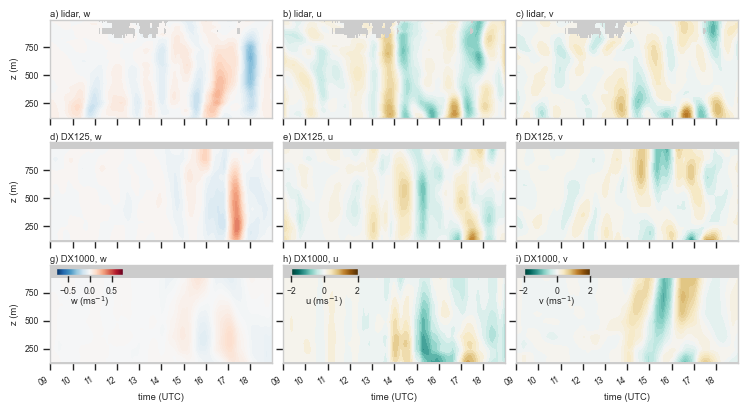

In [28]:
with (sns.plotting_context("paper", font_scale=0.7),):

    cm = 1 / 2.54  # centimeters in inches
    fig = plt.figure(figsize=(19 * cm, 28 * cm / 2))

    gs = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[4, 1.5])
    gs_stamps = gs[0].subgridspec(3, 3, wspace=0.05, hspace=0.25)

    cm = 1 / 2.54  # centimeters in inches
    fig = plt.figure(figsize=(19 * cm, 28 * cm / 2))

    gs = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[4, 1.5])
    gs_stamps = gs[0].subgridspec(3, 3, wspace=0.05, hspace=0.25)

    axes_stamps_u = []
    axes_stamps_v = []
    axes_stamps_w = []
    for n in range(3):
        axes_stamps_w.append(fig.add_subplot(gs_stamps[n, 0]))
        axes_stamps_u.append(fig.add_subplot(gs_stamps[n, 1]))
        axes_stamps_v.append(fig.add_subplot(gs_stamps[n, 2]))
    axes_dict = {
        "w": axes_stamps_w,
        "u": axes_stamps_u,
        "v": axes_stamps_v,
    }

    cmap = plt.get_cmap("BrBG_r").copy()
    cmap.set_bad("0.8")
    pcolor_kwargs_u_pert = {
        "vmin": -2.0,
        "vmax": 2.0,
        "cmap": cmap,
    }
    cmap = plt.get_cmap("RdBu_r").copy()
    cmap.set_bad("0.8")
    pcolor_kwargs_w = {
        "vmin": -0.75,
        "vmax": 0.75,
        "cmap": cmap,
    }
    cmap = plt.get_cmap("PuOr_r").copy()
    cmap.set_bad("0.8")
    pcolor_kwargs_u_full = {
        "vmin": -10,
        "vmax": 10,
        "cmap": cmap,
    }
    pad = 2

    pcolor_kwarg_dict = {
        "u": pcolor_kwargs_u_pert,
        "v": pcolor_kwargs_u_pert,
        "w": pcolor_kwargs_w,
    }

    t1 = pd.Timestamp("2019-09-14 09:00")
    t2 = pd.Timestamp("2019-09-14 18:59")
    tslice = slice(t1, t2)

    date_format = DateFormatter("%H")
    plot_band = band_ranges[1]

    # ---------------------------------------------------------
    # Plot
    domain_sub_list = ["lidar", "125m", "1km"]
    for ndomain, domain in enumerate(domain_sub_list):
        for ncomp, comp in enumerate(components):
            cluster_centers_periods = to_period(mrc_dict[domain].cluster_centroids)
            mrc = mrc_dict[domain]

            # Grab band
            band_index = np.flatnonzero(
                (cluster_centers_periods > plot_band[0])
                & (cluster_centers_periods < plot_band[1])
            )
            ds = ds_recon_list[domain][comp]
            ds = ds.isel(band=band_index).sum(dim="band").sel(time=slice(t1, t2))
            if domain == "lidar":
                ds = xr.where(np.isnan(lidar_mask.sel(time=tslice)), np.nan, ds)
                label = "lidar"
            else:
                label = domain_titles_dict[domain]

            ax = axes_dict[comp][ndomain]
            pcolor_kwargs = pcolor_kwarg_dict[comp]
            ax.contourf(
                ds.time,
                ds.height,
                ds,
                levels=20,
                **pcolor_kwargs,
            )
            alpha_num = (ndomain * 3) + ncomp
            ax.set_title(
                f"{alphabet[alpha_num]}) {label}, {comp}",
                loc="left",
                pad=pad,
            )
            ax.set_facecolor("0.8")
            ax.set_xlim(t1, t2)
            ax.grid(False)
            ax.xaxis.set_major_formatter(date_format)
            if ndomain == len(domain_sub_list) - 1:
                ax.set_xlabel("time (UTC)")
            else:
                ax.set_xticklabels([])
            if ncomp == 0:
                ax.set_ylabel("z (m)")
            else:
                ax.set_yticklabels([])
            ax.set_ylim(ds_data["lidar"].height.min(), ds_data["lidar"].height.max())

    # Colorbar - w
    norm = matplotlib.colors.Normalize(
        vmin=pcolor_kwargs_w["vmin"], vmax=pcolor_kwargs_w["vmax"]
    )
    cax = axes_stamps_w[-1].inset_axes([0.0275, 0.9, 0.3, 0.075])
    cbar = fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=norm, cmap=pcolor_kwargs_w["cmap"]),
        cax=cax,
        orientation="horizontal",
        shrink=0.2,
    )
    cbar.set_label(r"w (ms$^{-1}$)", labelpad=-0.8)

    # Colorbar - u
    norm = matplotlib.colors.Normalize(
        vmin=pcolor_kwargs_u_pert["vmin"], vmax=pcolor_kwargs_u_pert["vmax"]
    )
    cax = axes_stamps_u[-1].inset_axes([0.035, 0.9, 0.3, 0.075])
    cbar = fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=norm, cmap=pcolor_kwargs_u_pert["cmap"]),
        cax=cax,
        orientation="horizontal",
        shrink=0.2,
    )
    cbar.set_label(r"u (ms$^{-1}$)", labelpad=-0.8)

    # Colorbar - v
    norm = matplotlib.colors.Normalize(
        vmin=pcolor_kwargs_u_pert["vmin"], vmax=pcolor_kwargs_u_pert["vmax"]
    )
    cax = axes_stamps_v[-1].inset_axes([0.035, 0.9, 0.3, 0.075])
    cbar = fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=norm, cmap=pcolor_kwargs_u_pert["cmap"]),
        cax=cax,
        orientation="horizontal",
        shrink=0.2,
    )
    cbar.set_label(r"v (ms$^{-1}$)", labelpad=-0.8)

    fig.autofmt_xdate()
    fig.tight_layout()

    os.chdir(dir_print)
    fig.savefig("mbl-scales.stamp-plots.jpg", dpi=300, bbox_inches="tight")
    fig.savefig("mbl-scales.stamp-plots.png", dpi=300, bbox_inches="tight")
    fig.savefig("mbl-scales.stamp-plots.pdf", dpi=300, bbox_inches="tight")

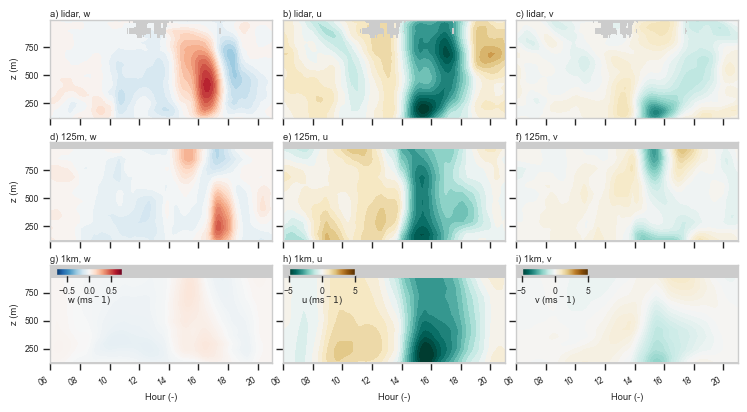

In [29]:
with (sns.plotting_context("paper", font_scale=0.7),):

    cm = 1 / 2.54  # centimeters in inches
    fig = plt.figure(figsize=(19 * cm, 28 * cm / 2))

    gs = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[4, 1.5])
    gs_stamps = gs[0].subgridspec(3, 3, wspace=0.05, hspace=0.25)

    axes_stamps_u = []
    axes_stamps_v = []
    axes_stamps_w = []
    for n in range(3):
        axes_stamps_w.append(fig.add_subplot(gs_stamps[n, 0]))
        axes_stamps_u.append(fig.add_subplot(gs_stamps[n, 1]))
        axes_stamps_v.append(fig.add_subplot(gs_stamps[n, 2]))
    axes_dict = {
        "w": axes_stamps_w,
        "u": axes_stamps_u,
        "v": axes_stamps_v,
    }

    cmap = plt.get_cmap("BrBG_r").copy()
    cmap.set_bad("0.8")
    pcolor_kwargs_u_pert = {
        "vmin": -5.0,
        "vmax": 5.0,
        "cmap": cmap,
    }
    cmap = plt.get_cmap("RdBu_r").copy()
    cmap.set_bad("0.8")
    pcolor_kwargs_w = {
        "vmin": -0.75,
        "vmax": 0.75,
        "cmap": cmap,
    }
    cmap = plt.get_cmap("PuOr_r").copy()
    cmap.set_bad("0.8")
    pcolor_kwargs_u_full = {
        "vmin": -10,
        "vmax": 10,
        "cmap": cmap,
    }
    pad = 2

    pcolor_kwarg_dict = {
        "u": pcolor_kwargs_u_pert,
        "v": pcolor_kwargs_u_pert,
        "w": pcolor_kwargs_w,
    }

    t1 = pd.Timestamp("2019-09-14 06:00")
    t2 = pd.Timestamp("2019-09-14 20:59")
    tslice = slice(t1, t2)

    date_format = DateFormatter("%H")
    plot_band = band_ranges[2]

    # ---------------------------------------------------------
    # Plot
    domain_sub_list = ["lidar", "125m", "1km"]
    for ndomain, domain in enumerate(domain_sub_list):
        for ncomp, comp in enumerate(components):
            cluster_centers_periods = to_period(mrc_dict[domain].cluster_centroids)
            mrc = mrc_dict[domain]

            # Grab band
            band_index = np.flatnonzero(
                (cluster_centers_periods > plot_band[0])
                & (cluster_centers_periods < plot_band[1])
            )
            ds = ds_recon_list[domain][comp]
            ds = ds.isel(band=band_index).sum(dim="band").sel(time=slice(t1, t2))
            if domain == "lidar":
                ds = xr.where(np.isnan(lidar_mask.sel(time=tslice)), np.nan, ds)

            ax = axes_dict[comp][ndomain]
            pcolor_kwargs = pcolor_kwarg_dict[comp]
            ax.contourf(
                ds.time,
                ds.height,
                ds,
                levels=20,
                **pcolor_kwargs,
            )
            alpha_num = (ndomain * 3) + ncomp
            ax.set_title(
                f"{alphabet[alpha_num]}) {domain}, {comp}",
                loc="left",
                pad=pad,
            )
            ax.set_facecolor("0.8")
            ax.set_xlim(t1, t2)
            ax.grid(False)
            ax.xaxis.set_major_formatter(date_format)
            if ndomain == len(domain_sub_list) - 1:
                ax.set_xlabel("Hour (-)")
            else:
                ax.set_xticklabels([])
            if ncomp == 0:
                ax.set_ylabel("z (m)")
            else:
                ax.set_yticklabels([])
            ax.set_ylim(ds_data["lidar"].height.min(), ds_data["lidar"].height.max())

    # Colorbar - w
    norm = matplotlib.colors.Normalize(
        vmin=pcolor_kwargs_w["vmin"], vmax=pcolor_kwargs_w["vmax"]
    )
    cax = axes_stamps_w[-1].inset_axes([0.025, 0.9, 0.3, 0.075])
    cbar = fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=norm, cmap=pcolor_kwargs_w["cmap"]),
        cax=cax,
        orientation="horizontal",
        shrink=0.2,
    )
    cbar.set_label(f"w (ms$^{-1}$)", labelpad=-0.8)

    # Colorbar - u
    norm = matplotlib.colors.Normalize(
        vmin=pcolor_kwargs_u_pert["vmin"], vmax=pcolor_kwargs_u_pert["vmax"]
    )
    cax = axes_stamps_u[-1].inset_axes([0.025, 0.9, 0.3, 0.075])
    cbar = fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=norm, cmap=pcolor_kwargs_u_pert["cmap"]),
        cax=cax,
        orientation="horizontal",
        shrink=0.2,
    )
    cbar.set_label(f"u (ms$^{-1}$)", labelpad=-0.8)

    # Colorbar - v
    norm = matplotlib.colors.Normalize(
        vmin=pcolor_kwargs_u_pert["vmin"], vmax=pcolor_kwargs_u_pert["vmax"]
    )
    cax = axes_stamps_v[-1].inset_axes([0.025, 0.9, 0.3, 0.075])
    cbar = fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=norm, cmap=pcolor_kwargs_u_pert["cmap"]),
        cax=cax,
        orientation="horizontal",
        shrink=0.2,
    )
    cbar.set_label(f"v (ms$^{-1}$)", labelpad=-0.8)

    fig.autofmt_xdate()
    fig.tight_layout()

# Diurnal scales

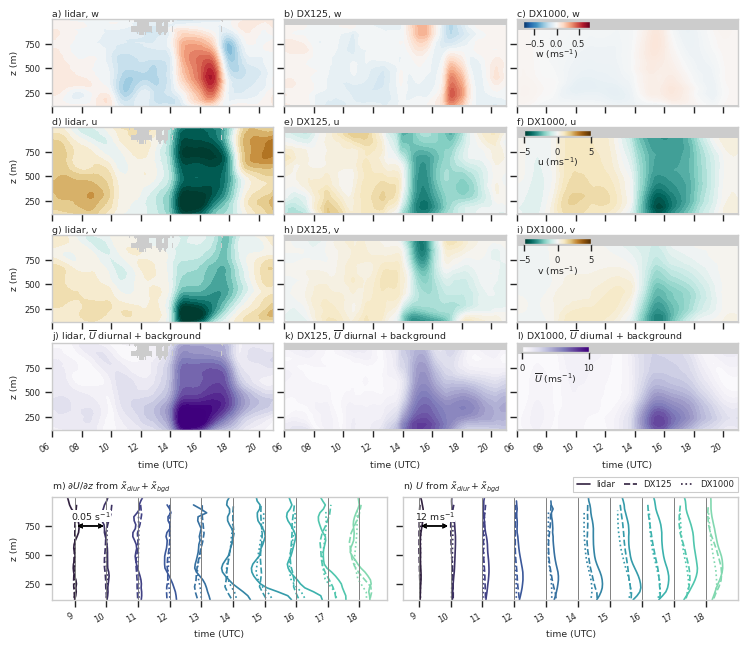

In [30]:
with (sns.plotting_context("paper", font_scale=0.7),):

    cm = 1 / 2.54  # centimeters in inches
    fig = plt.figure(figsize=(19 * cm, 33 * cm / 2))

    gs = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[4, 1])
    gs_stamps = gs[0].subgridspec(4, 3, wspace=0.05, hspace=0.25)

    axes_stamps_u = []
    axes_stamps_v = []
    axes_stamps_w = []
    axes_stamps_bgd = []
    for n in range(3):
        axes_stamps_w.append(fig.add_subplot(gs_stamps[0, n]))
        axes_stamps_u.append(fig.add_subplot(gs_stamps[1, n]))
        axes_stamps_v.append(fig.add_subplot(gs_stamps[2, n]))
    for n in range(3):
        axes_stamps_bgd.append(fig.add_subplot(gs_stamps[3, n]))
    axes_dict = {
        "w": axes_stamps_w,
        "u": axes_stamps_u,
        "v": axes_stamps_v,
        "bgd": axes_stamps_bgd,
    }

    gs_profiles = gs[1].subgridspec(1, 2, wspace=0.05, hspace=0.25)
    ax_dudz = fig.add_subplot(gs_profiles[0, 0])
    ax_ubar = fig.add_subplot(gs_profiles[0, 1])

    pad = 2

    cmap = plt.get_cmap("BrBG_r").copy()
    cmap.set_bad("0.8")
    pcolor_kwargs_u_pert = {
        "vmin": -5.0,
        "vmax": 5.0,
        "cmap": cmap,
    }
    cmap = plt.get_cmap("RdBu_r").copy()
    cmap.set_bad("0.8")
    pcolor_kwargs_w = {
        "vmin": -0.75,
        "vmax": 0.75,
        "cmap": cmap,
    }
    cmap = plt.get_cmap("PuOr_r").copy()
    cmap.set_bad("0.8")
    pcolor_kwargs_u_full = {
        "vmin": -10,
        "vmax": 10,
        "cmap": cmap,
    }
    cmap = plt.get_cmap("Purples").copy()
    cmap.set_bad("0.8")
    pcolor_kwargs_bgd = {
        "vmin": 0,
        "vmax": 10,
        "cmap": cmap,
    }

    pcolor_kwarg_dict = {
        "u": pcolor_kwargs_u_pert,
        "v": pcolor_kwargs_u_pert,
        "w": pcolor_kwargs_w,
        "bgd": pcolor_kwargs_bgd,
    }

    t1 = pd.Timestamp("2019-09-14 06:00")
    t2 = pd.Timestamp("2019-09-14 20:59")
    tslice = slice(t1, t2)

    t1_profile = pd.Timestamp("2019-09-14 09:00")
    t2_profile = pd.Timestamp("2019-09-14 18:59")
    tslice_profile = slice(t1_profile, t2_profile)

    date_format = DateFormatter("%H")
    plot_band = band_ranges[2]

    # ---------------------------------------------------------
    # Plot
    domain_sub_list = ["lidar", "125m", "1km"]
    for ndomain, domain in enumerate(domain_sub_list):
        for ncomp, comp in enumerate(components):
            cluster_centers_periods = to_period(mrc_dict[domain].cluster_centroids)
            mrc = mrc_dict[domain]

            # Grab band
            band_index = np.flatnonzero(
                (cluster_centers_periods > plot_band[0])
                & (cluster_centers_periods < plot_band[1])
            )
            ds = ds_recon_list[domain][comp]
            ds = ds.isel(band=band_index).sum(dim="band").sel(time=slice(t1, t2))
            if domain == "lidar":
                ds = xr.where(np.isnan(lidar_mask.sel(time=tslice)), np.nan, ds)

            ax = axes_dict[comp][ndomain]
            pcolor_kwargs = pcolor_kwarg_dict[comp]
            ax.contourf(
                ds.time,
                ds.height,
                ds,
                levels=20,
                **pcolor_kwargs,
            )
            alpha_num = ndomain + (ncomp * 3)
            dtitle = domain_titles_dict[domain]
            ax.set_title(
                f"{alphabet[alpha_num]}) {dtitle}, {comp}",
                loc="left",
                pad=pad,
            )
            ax.set_facecolor("0.8")
            ax.set_xlim(t1, t2)
            ax.grid(False)
            ax.xaxis.set_major_formatter(date_format)
            ax.set_xticklabels([])
            if ndomain == 0:
                ax.set_ylabel("z (m)")
            else:
                ax.set_yticklabels([])
            ax.set_ylim(ds_data["lidar"].height.min(), ds_data["lidar"].height.max())

    # Colorbar - w
    norm = matplotlib.colors.Normalize(
        vmin=pcolor_kwargs_w["vmin"], vmax=pcolor_kwargs_w["vmax"]
    )
    cax = axes_stamps_w[-1].inset_axes([0.03, 0.9, 0.3, 0.075])
    cbar = fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=norm, cmap=pcolor_kwargs_w["cmap"]),
        cax=cax,
        orientation="horizontal",
        shrink=0.2,
    )
    cbar.set_label(r"w (ms$^{-1}$)", labelpad=-0.8)

    # Colorbar - u
    norm = matplotlib.colors.Normalize(
        vmin=pcolor_kwargs_u_pert["vmin"], vmax=pcolor_kwargs_u_pert["vmax"]
    )
    cax = axes_stamps_u[-1].inset_axes([0.035, 0.9, 0.3, 0.075])
    cbar = fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=norm, cmap=pcolor_kwargs_u_pert["cmap"]),
        cax=cax,
        orientation="horizontal",
        shrink=0.2,
    )
    cbar.set_label(r"u (ms$^{-1}$)", labelpad=-0.8)

    # Colorbar - v
    norm = matplotlib.colors.Normalize(
        vmin=pcolor_kwargs_u_pert["vmin"], vmax=pcolor_kwargs_u_pert["vmax"]
    )
    cax = axes_stamps_v[-1].inset_axes([0.035, 0.9, 0.3, 0.075])
    cbar = fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=norm, cmap=pcolor_kwargs_u_pert["cmap"]),
        cax=cax,
        orientation="horizontal",
        shrink=0.2,
    )
    cbar.set_label(r"v (ms$^{-1}$)", labelpad=-0.8)

    # -----------------------------------------------------------------------------------=
    # Background + Diurnal scales

    domain_sub_list = ["lidar", "125m", "1km"]
    for ndomain, domain in enumerate(domain_sub_list):
        cluster_centers_periods = to_period(mrc_dict[domain].cluster_centroids)
        mrc = mrc_dict[domain]

        # Grab band
        band_index = np.flatnonzero(
            (cluster_centers_periods > plot_band[0])
            & (cluster_centers_periods < plot_band[1])
        )
        ds = ds_recon_list[domain]
        ds = ds.isel(band=band_index).sum(dim="band").sel(time=slice(t1, t2))
        ds = ds + ds_background_dict[domain][comp].sel(time=slice(t1, t2))
        ds = np.sqrt(ds["u"] ** 2 + ds["v"] ** 2)

        if domain == "lidar":
            ds = xr.where(np.isnan(lidar_mask.sel(time=tslice)), np.nan, ds)

        ax = axes_dict["bgd"][ndomain]
        pcolor_kwargs = pcolor_kwarg_dict["bgd"]
        ax.contourf(
            ds.time,
            ds.height,
            ds,
            levels=20,
            **pcolor_kwargs,
        )
        alpha_num = ndomain + 9
        dtitle = domain_titles_dict[domain]
        ax.set_title(
            f"{alphabet[alpha_num]}) {dtitle}, ${{\\overline{{U}}}}$ diurnal + background",
            loc="left",
            pad=pad,
        )
        ax.set_facecolor("0.8")
        ax.set_xlim(t1, t2)
        ax.grid(False)
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("time (UTC)")
        if ndomain == 0:
            ax.set_ylabel("z (m)")
        else:
            ax.set_yticklabels([])
        ax.set_ylim(ds_data["lidar"].height.min(), ds_data["lidar"].height.max())

        if ndomain == 2:
            # Colorbar: background + diurnal scales
            norm = matplotlib.colors.Normalize(
                vmin=pcolor_kwargs_bgd["vmin"], vmax=pcolor_kwargs_bgd["vmax"]
            )
            cax = ax.inset_axes([0.025, 0.9, 0.3, 0.075])
            cbar = fig.colorbar(
                matplotlib.cm.ScalarMappable(norm=norm, cmap=pcolor_kwargs_bgd["cmap"]),
                cax=cax,
                orientation="horizontal",
                shrink=0.2,
            )
            cbar.set_label(r"$\overline{U}$ (ms$^{-1}$)", labelpad=-0.8)

        # Profiles!
        dt_sample = "60min"
        hour_scaling = 1

        ds_hrly = ds.resample(time=dt_sample).mean(dim="time").sel(time=tslice_profile)
        ds_hrly_deriv = ds_hrly.differentiate(coord="height")
        ds_hrly_dict = {"ubar": ds_hrly, "dudz": ds_hrly_deriv}
        ax_profile_dict = {"ubar": ax_ubar, "dudz": ax_dudz}
        scaling_dict = {"ubar": 12, "dudz": 0.05}
        title_dict = {"ubar": r"U", "dudz": r"\partial U/\partial z"}
        unit_dict = {"ubar": "m", "dudz": ""}

        palette = sns.color_palette("mako", len(ds_hrly.time) + 2)
        palette = palette[1:-1]

        hours = np.unique(ds_hrly["time.hour"])

        if domain == "lidar":
            ls = "-"
        elif domain == "125m":
            ls = "--"
        elif domain == "1km":
            ls = ":"

        for nprofile, profile_type in enumerate(["dudz", "ubar"]):
            ax = ax_profile_dict[profile_type]
            ds_plot = ds_hrly_dict[profile_type]
            plot_scale = scaling_dict[profile_type]

            for nhour, hour in enumerate(ds_hrly.time):
                if nhour == 0:
                    label = domain_titles_dict[domain]
                else:
                    label = None
                ax.plot(
                    np.ones(len(ds_recon_list[domain].height))
                    * (nhour + 1)
                    * plot_scale
                    + ds_plot.sel(time=hour),
                    ds_recon_list[domain].height,
                    color=palette[nhour],
                    ls=ls,
                    label=label,
                )
                ax.axvline((nhour + 1) * plot_scale, lw=0.5, color="0.5")

            ax.grid(False)
            ticks = (
                np.arange(1, len(hours) * hour_scaling + 1, hour_scaling) * plot_scale
            )
            ax.set_xticks(ticks)
            ax.set_xticklabels(hours)
            if nprofile == 0:
                ax.set_ylabel("z (m)")
            else:
                ax.set_yticklabels([])
            ax.set_xlabel("time (UTC)")
            ax.set_ylim(ds_data["lidar"].height.min(), ds_data["lidar"].height.max())
            ax.set_title(
                f"{alphabet[12 + nprofile]}) ${title_dict[profile_type]}$ from $\\tilde{{x}}_{{diur}} + \\tilde{{x}}_{{bgd}}$",
                loc="left",
            )
            arr = ax.annotate(
                "",
                xy=(ticks[1], 750),
                xytext=(ticks[0], 750),
                arrowprops=dict(arrowstyle="<->", color="k"),
            )

            ax.annotate(
                f"{plot_scale} {unit_dict[profile_type]}s$^{{-1}}$",
                (0.6, 1.5),
                xycoords=arr,
                ha="center",
                va="bottom",
                bbox=dict(boxstyle="square,pad=0", fc="white", ec="None", alpha=0.9),
            )

            if nprofile == 1:
                ax.legend(
                    loc="upper right",
                    ncols=3,
                    bbox_to_anchor=(1.0, 1.2),
                    fancybox=False,
                    framealpha=1,
                    borderaxespad=0,
                    handlelength=1.5,
                    columnspacing=1,
                )

    fig.autofmt_xdate()
    fig.tight_layout()

    os.chdir(dir_print)
    fig.savefig("valley-wind-scales.stamp-plots.jpg", dpi=300, bbox_inches="tight")
    fig.savefig("valley-wind-scales.stamp-plots.png", dpi=300, bbox_inches="tight")
    fig.savefig("valley-wind-scales.stamp-plots.pdf", dpi=300, bbox_inches="tight")